In [1]:
import ee
import geemap

## Estimating Forest Cover Density and Land Area Coverage for Nigeria States

I am using the [FAO GAUL: Global Administrative Unit Layers 2015, First-Level Administrative Units](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level1) from FAO UN for extracting the study area (roi) and the [Global 4-class PALSAR-2/PALSAR Forest/Non-Forest Map](https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_PALSAR_YEARLY_FNF4#bands) from JAXA EORC for the Forest Cover Analysis.

In [2]:
# extracting region of interest (Nigeria) from the FAO Administrative Units Data

m = geemap.Map(center=[9,7], zoom=6, height='500px')
nija = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))
m.addLayer(nija, {}, 'Nigeria Boundary')
m

Map(center=[9, 7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [3]:
dataset = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF4').filterDate('2020-01-01', '2020-12-31').select('fnf')
dataset

In [18]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}

fnf = dataset.map(lambda img: img.clipToCollection(nija))
m.centerObject(nija, zoom=6)
m.addLayer(fnf, fnfVis, 'Forest/Non-Forest')
m.addLayer(nija.style(**vis_params), {}, 'Nigeria')
text = 'Map Created by Emeka Orji'
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_text(text)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict, layer_name='Forest/Non-Forest')
m

Map(center=[9.589444610453397, 8.089338153274129], controls=(WidgetControl(options=['position', 'transparent_b…

In [56]:
fc = geemap.zonal_stats_by_group(fnf, nija, out_file_path=None, stat_type='SUM', decimal_places=2, denominator=1e6, return_fc=True)

Computing ... 


In [64]:
# Converting the google earth engine feature to dataframe and checking for percentage of total state land area (Class_sum) 
#with dense forest (Class_1) in Nigeria

nija_fnf = geemap.ee_to_df(fc)
nija_fnf['class1_percent'] = ((nija_fnf['Class_1'] / nija_fnf['Class_sum']) * 100).round(2)
nija_fnf.sort_values('class1_percent', ascending=False).head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,class1_percent
19,182,Nigeria,2217,Cross River,10304.72,8291.73,2067.16,346.12,21009.73,NO,3000,Member State,1000,1.715713,10.919583,49.05
2,182,Nigeria,65700,Bayelsa,3476.32,4943.25,984.11,587.59,9991.27,NO,3000,Member State,1997,0.814464,8.485513,34.79
33,182,Nigeria,2234,Osun,1926.44,5885.83,1320.94,56.60,9189.81,NO,3000,Member State,1000,0.752934,4.380049,20.96
10,182,Nigeria,65708,Rivers,1648.67,4469.80,2160.21,447.94,8726.62,NO,3000,Member State,1997,0.711474,10.311515,18.89
8,182,Nigeria,65706,Ondo,2716.02,10063.29,1578.99,110.85,14469.15,NO,3000,Member State,1997,1.183914,8.104566,18.77
35,182,Nigeria,2239,Taraba,10463.50,19697.32,29361.91,907.49,60430.22,NO,3000,Member State,1000,4.957189,13.739033,17.32
4,182,Nigeria,65702,Ekiti,846.49,3730.06,653.69,6.27,5236.51,NO,3000,Member State,1997,0.429200,3.198663,16.17
20,182,Nigeria,2218,Delta,2663.74,9215.86,4347.97,546.27,16773.84,NO,3000,Member State,1000,1.369407,11.554842,15.88
0,182,Nigeria,65698,Abia,656.35,3043.33,1014.05,10.15,4723.88,NO,3000,Member State,1997,0.385485,4.198984,13.89
21,182,Nigeria,2219,Edo,2370.24,13686.65,3430.42,101.79,19589.10,NO,3000,Member State,1000,1.601900,7.455604,12.10


In [65]:
nija_fnf[nija_fnf['class1_percent'] < 1].shape

(11, 16)

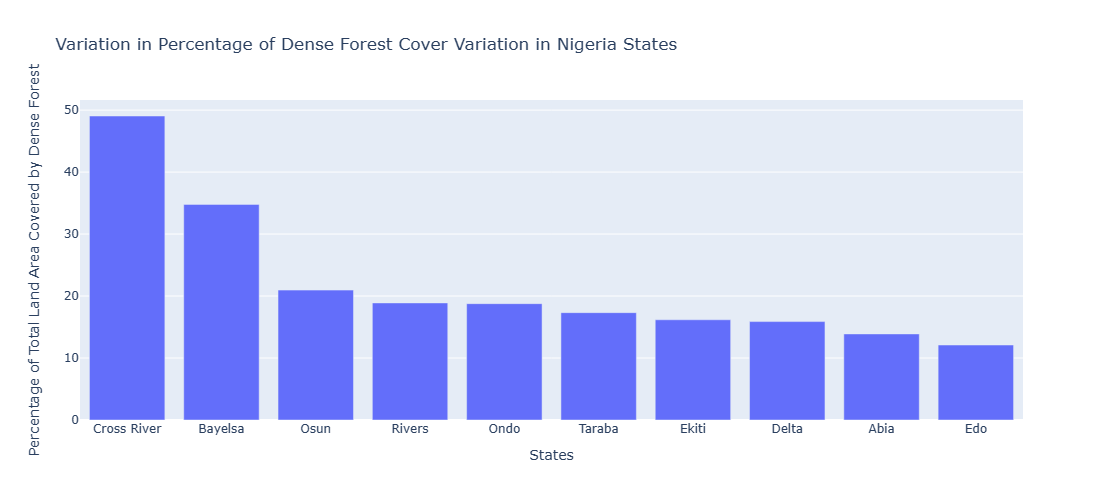

In [66]:
geemap.bar_chart(data=nija_fnf, x='ADM1_NAME', y='class1_percent', x_label= 'States', y_label='Percentage of Total Land Area Covered by Dense Forest', 
                 title='Variation in Percentage of Dense Forest Cover Variation in Nigeria States',max_rows=10)

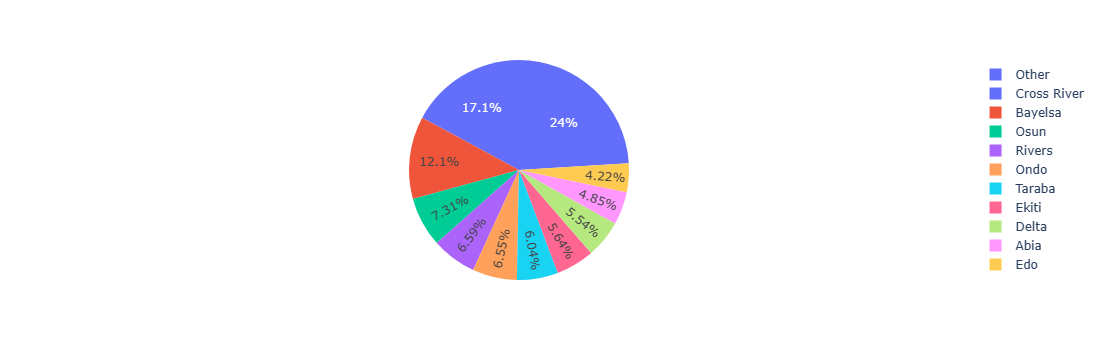

In [67]:
geemap.pie_chart(nija_fnf, names='ADM1_NAME', values='class1_percent', max_rows=11, color='ADM1_NAME')

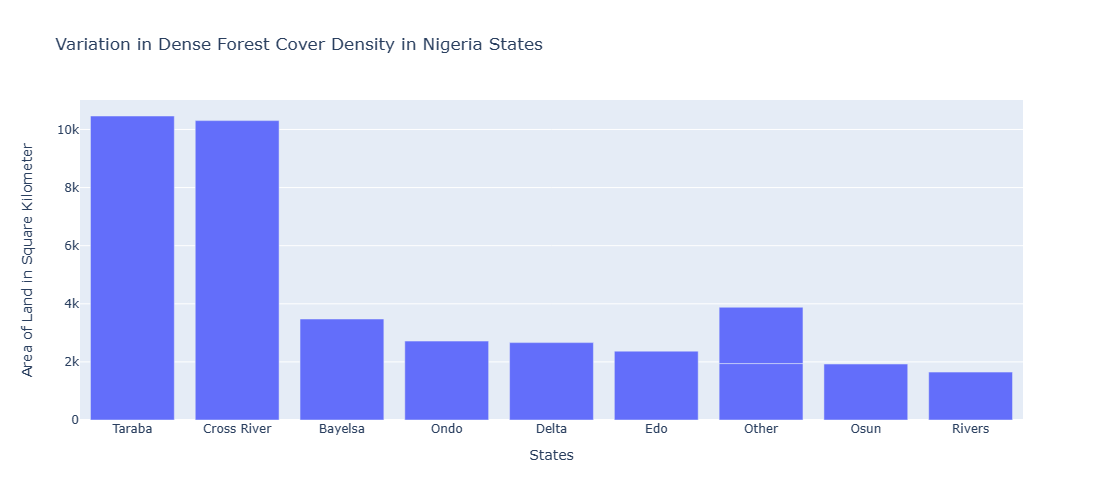

In [68]:
geemap.bar_chart(data=nija_fnf, x='ADM1_NAME', y='Class_1', x_label= 'States', y_label='Area of Land in Square Kilometer', 
                 title='Variation in Dense Forest Cover Density in Nigeria States',max_rows=10)

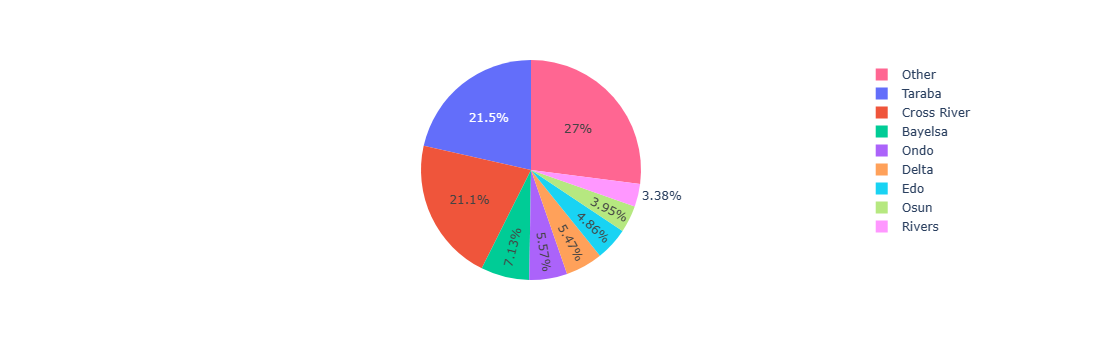

In [69]:
geemap.pie_chart(nija_fnf, names='ADM1_NAME', values='Class_1', max_rows=11, color='ADM1_NAME')

### Evaluating Variation in Dense Forest Land Cover in South-East and South-South States of Nigeria

In [70]:
m = geemap.Map(center=[9,7], zoom=6, height='500px')
ss_se_states = nija.filter(
    ee.Filter.inList('ADM1_NAME', ['Edo', 'Akwa Ibom', 'Cross River', 'Rivers', 'Bayelsa', 'Delta', 'Imo', 'Abia', 'Anambra', 'Ebonyi', 'Enugu'])
)
imo = ss_se_states.filter(ee.Filter.eq('ADM1_NAME', 'Imo'))
m.centerObject(imo, zoom=8)
m.addLayer(ss_se_states, {}, 'SS / SE States Boundary')
m

Map(center=[5.550234088402793, 7.0468337804945], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [71]:
from geemap.legends import builtin_legends

for legend in builtin_legends:
    print(legend)

NLCD
ESA_WorldCover
ESRI_LandCover
ESRI_LandCover_TS
Dynamic_World
NWI
MODIS/051/MCD12Q1
MODIS/006/MCD12Q1
GLOBCOVER
JAXA/PALSAR
Oxford
AAFC/ACI
COPERNICUS/CORINE/V20/100m
COPERNICUS/Landcover/100m/Proba-V/Global
USDA/NASS/CDL
ALOS_landforms


In [72]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000',
}

se_fnf = dataset.map(lambda img: img.clipToCollection(ss_se_states))
m.centerObject(imo, zoom=8)
m.addLayer(se_fnf, fnfVis, 'Forest/Non-Forest')
m.addLayer(ss_se_states.style(**vis_params), {}, 'SS States')
text = 'Map Created by Emeka Orji'
m.add_text(text)
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict)
m

Map(center=[5.550234088402793, 7.0468337804945], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [73]:
m.add_labels(
    data=ss_se_states,
    column="ADM1_NAME",
    font_size="8pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=True,
)

#### To Download resulting Image to my local computer with less spatial resolution(i.e using a scaling:250) image is originally 25m resolution

In [24]:
region = ee.Geometry.BBox(4.713751, 4.107652, 9.725036, 7.865649)
fc = ee.FeatureCollection(region)
m.addLayer(fc, {}, 'region', False)

In [25]:
sefnf = se_fnf.first()
m.addLayer(sefnf, fnfVis, 'SE Forest/Non-Forest', shown=False)
sefnf

In [26]:
project = sefnf.projection()
project

In [27]:
crs = project.crs()

In [28]:
geemap.download_ee_image(sefnf, filename='testing_cover.tif', scale=250, crs=crs, region=region)

testing_cover.tif: |                                                  | 0.00/3.74M (raw) [  0.0%] in 00:00 (et…

In [74]:
fc = geemap.zonal_stats_by_group(fnf, ss_se_states, out_file=None, stat_type='SUM', decimal_places=2, denominator=1e6, return_fc=True)

Computing ... 


In [75]:
ss_se_fnf = geemap.ee_to_df(fc)
ss_se_fnf.sort_values('Class_1', ascending=False)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
7,182,Nigeria,2217,Cross River,10304.72,8291.73,2067.16,346.12,21009.73,NO,3000,Member State,1000,1.715713,10.919583
1,182,Nigeria,65700,Bayelsa,3476.32,4943.25,984.11,587.59,9991.27,NO,3000,Member State,1997,0.814464,8.485513
8,182,Nigeria,2218,Delta,2663.74,9215.86,4347.97,546.27,16773.84,NO,3000,Member State,1000,1.369407,11.554842
9,182,Nigeria,2219,Edo,2370.24,13686.65,3430.42,101.79,19589.10,NO,3000,Member State,1000,1.601900,7.455604
4,182,Nigeria,65708,Rivers,1648.67,4469.80,2160.21,447.94,8726.62,NO,3000,Member State,1997,0.711474,10.311515
0,182,Nigeria,65698,Abia,656.35,3043.33,1014.05,10.15,4723.88,NO,3000,Member State,1997,0.385485,4.198984
3,182,Nigeria,65703,Enugu,621.61,4906.44,2162.20,12.18,7702.43,NO,3000,Member State,1997,0.629751,4.118491
10,182,Nigeria,2222,Imo,505.90,3742.85,1027.54,33.83,5310.12,NO,3000,Member State,1000,0.433385,2.713051
5,182,Nigeria,2212,Akwa Ibom,421.39,4439.53,1668.32,81.82,6611.06,NO,3000,Member State,1000,0.539042,6.186270
6,182,Nigeria,2213,Anambra,237.81,1762.22,2493.47,96.63,4590.13,NO,3000,Member State,1000,0.375060,3.465664


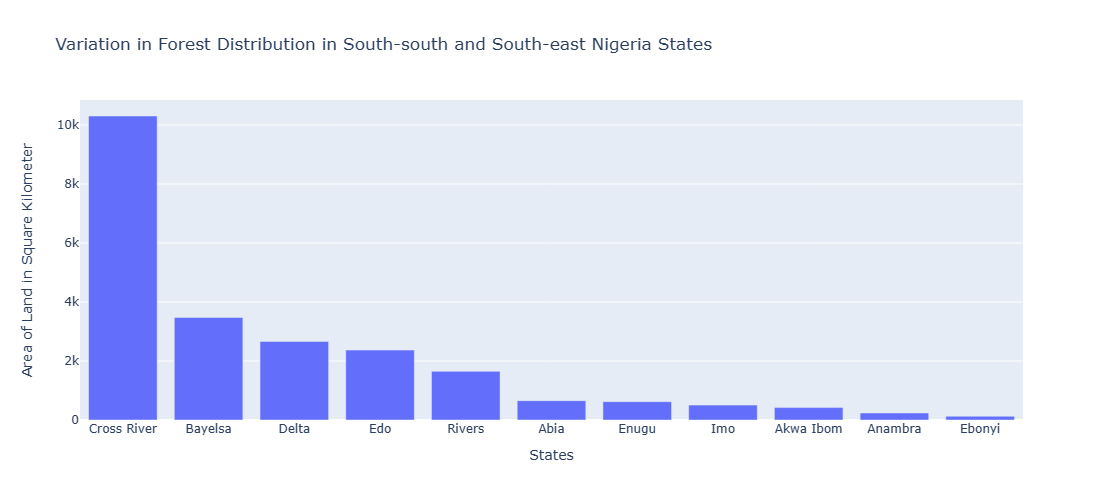

In [76]:
geemap.bar_chart(data=ss_se_fnf, x='ADM1_NAME', y='Class_1', x_label= 'States', y_label='Area of Land in Square Kilometer', 
                 title='Variation in Forest Distribution in South-south and South-east Nigeria States')

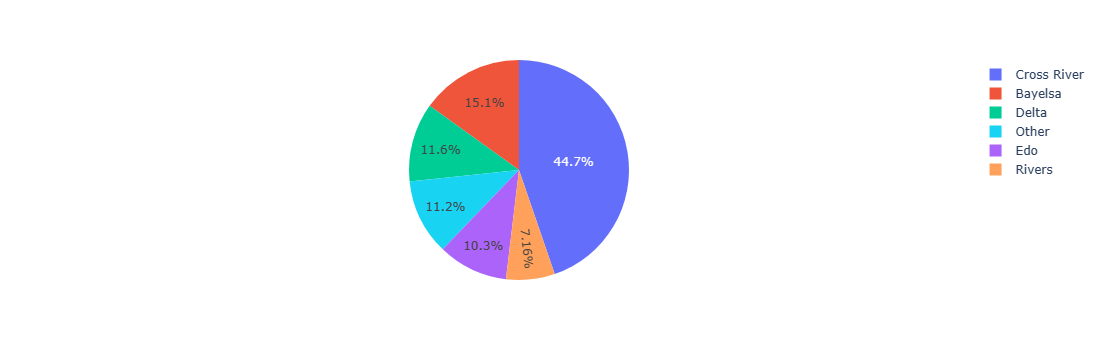

In [77]:
geemap.pie_chart(ss_se_fnf, names='ADM1_NAME', values='Class_1', max_rows=6, color='ADM1_NAME')

In [80]:
ss_se_fnf['class1_percent'] = ((ss_se_fnf['Class_1'] / ss_se_fnf['Class_sum']) * 100).round(2)
ss_se_fnf.sort_values('class1_percent', ascending=False).head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,class1_percent
7,182,Nigeria,2217,Cross River,10304.72,8291.73,2067.16,346.12,21009.73,NO,3000,Member State,1000,1.715713,10.919583,49.05
1,182,Nigeria,65700,Bayelsa,3476.32,4943.25,984.11,587.59,9991.27,NO,3000,Member State,1997,0.814464,8.485513,34.79
4,182,Nigeria,65708,Rivers,1648.67,4469.80,2160.21,447.94,8726.62,NO,3000,Member State,1997,0.711474,10.311515,18.89
8,182,Nigeria,2218,Delta,2663.74,9215.86,4347.97,546.27,16773.84,NO,3000,Member State,1000,1.369407,11.554842,15.88
0,182,Nigeria,65698,Other,656.35,3043.33,1014.05,10.15,4723.88,NO,3000,Member State,1997,0.385485,4.198984,13.89
9,182,Nigeria,2219,Edo,2370.24,13686.65,3430.42,101.79,19589.10,NO,3000,Member State,1000,1.601900,7.455604,12.10
10,182,Nigeria,2222,Other,505.90,3742.85,1027.54,33.83,5310.12,NO,3000,Member State,1000,0.433385,2.713051,9.53
3,182,Nigeria,65703,Other,621.61,4906.44,2162.20,12.18,7702.43,NO,3000,Member State,1997,0.629751,4.118491,8.07
5,182,Nigeria,2212,Other,421.39,4439.53,1668.32,81.82,6611.06,NO,3000,Member State,1000,0.539042,6.186270,6.37
6,182,Nigeria,2213,Other,237.81,1762.22,2493.47,96.63,4590.13,NO,3000,Member State,1000,0.375060,3.465664,5.18


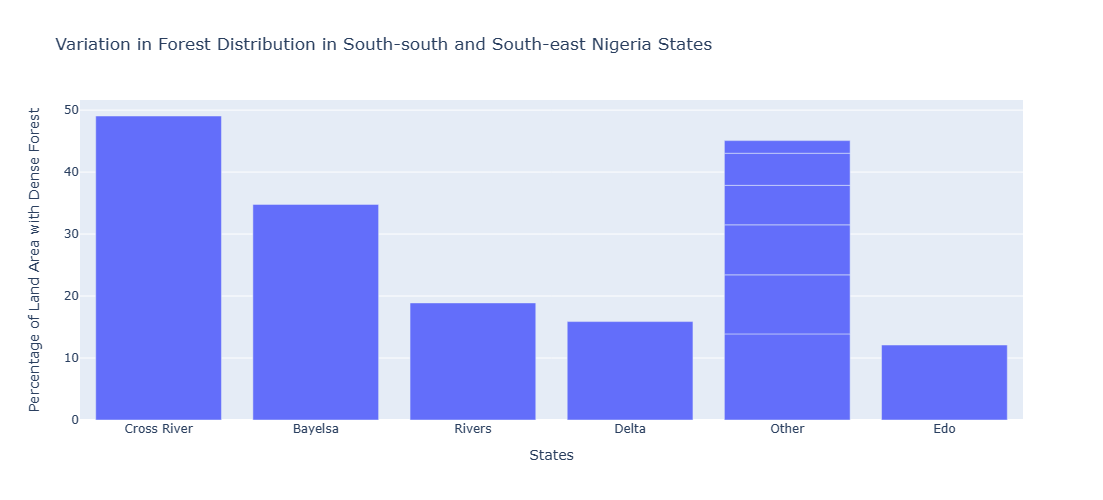

In [81]:
geemap.bar_chart(data=ss_se_fnf, x='ADM1_NAME', y='class1_percent', x_label= 'States', y_label='Percentage of Land Area with Dense Forest', 
                 title='Variation in Forest Distribution in South-south and South-east Nigeria States')

## Evaluating Disparity in Dense Forest Region in North Eastern Nigeria

In [82]:
m = geemap.Map()
ne_states = nija.filter(
    ee.Filter.inList('ADM1_NAME', ['Adamawa', 'Bauchi', 'Borno', 'Gombe', 'Taraba', 'Yobe'])
)
gombe = ne_states.filter(ee.Filter.eq('ADM1_NAME', 'Gombe'))
m.centerObject(gombe, zoom=7)
m.addLayer(ne_states, {}, 'North Eastern States Boundary')
m

Map(center=[10.404839156412304, 11.244955239828244], controls=(WidgetControl(options=['position', 'transparent…

In [83]:
m = geemap.Map()

legend_dict = {
    '1 Dense Forest': '#00b200',
    '2 Non-dense Forest': '#83ef62',
    '3 Non-Forest': '#ffff99',
    '4 Water': '#0000ff',
}

fnfVis = {
  'min': 1,
  'max': 4,
  'palette': ['00b200','83ef62','ffff99','0000ff'],
}

vis_params = {
    'color': '#000000',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000',
}


fnf = dataset.map(lambda img: img.clipToCollection(ne_states))
m.centerObject(gombe, zoom=7)
m.addLayer(nija.style(fillColor='00000000', width=0.5), {}, 'Nigeria')
m.addLayer(fnf, fnfVis, 'NE Forest/Non-Forest')
m.addLayer(ne_states.style(**vis_params), {}, 'NE States')
text = 'Map Created by Emeka Orji'
m.add_text(text)
text2 = 'Data Source: JAXA EORC and FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_legend(title='Forest/Non-Forest Classification', legend_dict=legend_dict, layer_name='NE Forest/Non-Forest')
m

Map(center=[10.404839156412304, 11.244955239828244], controls=(WidgetControl(options=['position', 'transparent…

In [84]:
m.add_labels(
    data=ne_states,
    column="ADM1_NAME",
    font_size="8pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=True,
)

In [87]:
fc = geemap.zonal_stats_by_group(fnf, ne_states, out_file=None, stat_type='SUM', decimal_places=2, denominator=1e6, return_fc=True)

Computing ... 


In [88]:
ne_fnf = geemap.ee_to_df(fc)
ne_fnf.sort_values('Class_1', ascending=False)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
4,182,Nigeria,2239,Taraba,10463.50,19697.32,29361.91,907.49,60430.22,NO,3000,Member State,1000,4.957189,13.739033
2,182,Nigeria,2211,Adamawa,1938.54,6101.82,25977.92,373.24,34391.52,NO,3000,Member State,1000,2.830909,11.814723
0,182,Nigeria,65699,Bauchi,444.96,5976.09,42311.67,327.30,49060.02,NO,3000,Member State,1997,4.055679,12.903322
1,182,Nigeria,65704,Gombe,67.63,890.54,16907.15,324.91,18190.23,NO,3000,Member State,1997,1.501908,5.521496
3,182,Nigeria,2216,Borno,25.98,3582.34,67208.53,779.02,71595.87,NO,3000,Member State,1000,5.941520,13.717056
5,182,Nigeria,2240,Yobe,1.85,545.13,44908.08,117.44,45572.50,NO,3000,Member State,1000,3.787278,10.339501


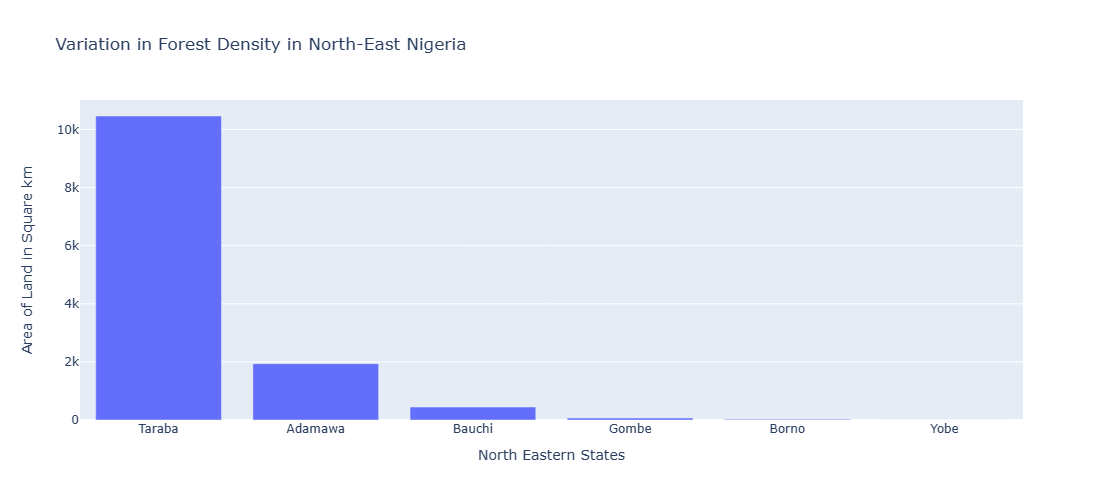

In [89]:
geemap.bar_chart(data=ne_fnf, x='ADM1_NAME', y='Class_1', x_label= 'North Eastern States', y_label='Area of Land in Square km', 
                 title='Variation in Forest Density in North-East Nigeria')

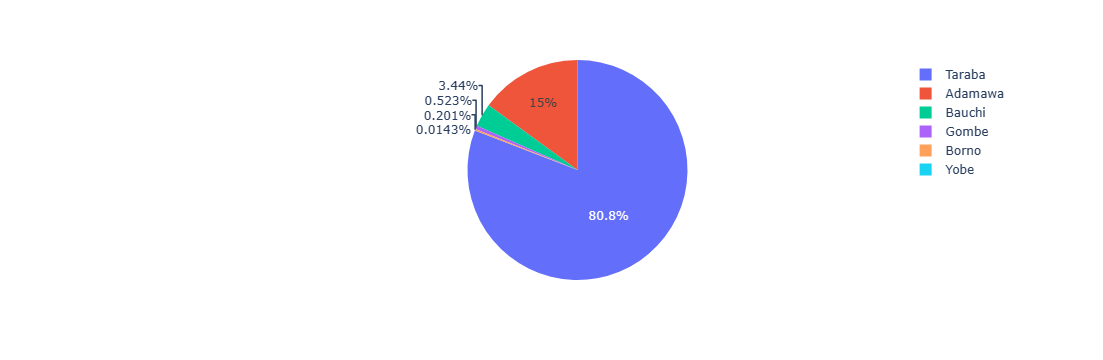

In [90]:
geemap.pie_chart(ne_fnf, names='ADM1_NAME', values='Class_1', color='ADM1_NAME')

In [91]:
ne_fnf['class1_percent'] = ((ne_fnf['Class_1'] / ne_fnf['Class_sum']) * 100).round(2)
ne_fnf.sort_values('class1_percent', ascending=False).head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,Class_1,Class_2,Class_3,Class_4,Class_sum,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,class1_percent
4,182,Nigeria,2239,Taraba,10463.50,19697.32,29361.91,907.49,60430.22,NO,3000,Member State,1000,4.957189,13.739033,17.32
2,182,Nigeria,2211,Adamawa,1938.54,6101.82,25977.92,373.24,34391.52,NO,3000,Member State,1000,2.830909,11.814723,5.64
0,182,Nigeria,65699,Bauchi,444.96,5976.09,42311.67,327.30,49060.02,NO,3000,Member State,1997,4.055679,12.903322,0.91
1,182,Nigeria,65704,Gombe,67.63,890.54,16907.15,324.91,18190.23,NO,3000,Member State,1997,1.501908,5.521496,0.37
3,182,Nigeria,2216,Borno,25.98,3582.34,67208.53,779.02,71595.87,NO,3000,Member State,1000,5.941520,13.717056,0.04
5,182,Nigeria,2240,Yobe,1.85,545.13,44908.08,117.44,45572.50,NO,3000,Member State,1000,3.787278,10.339501,0.00


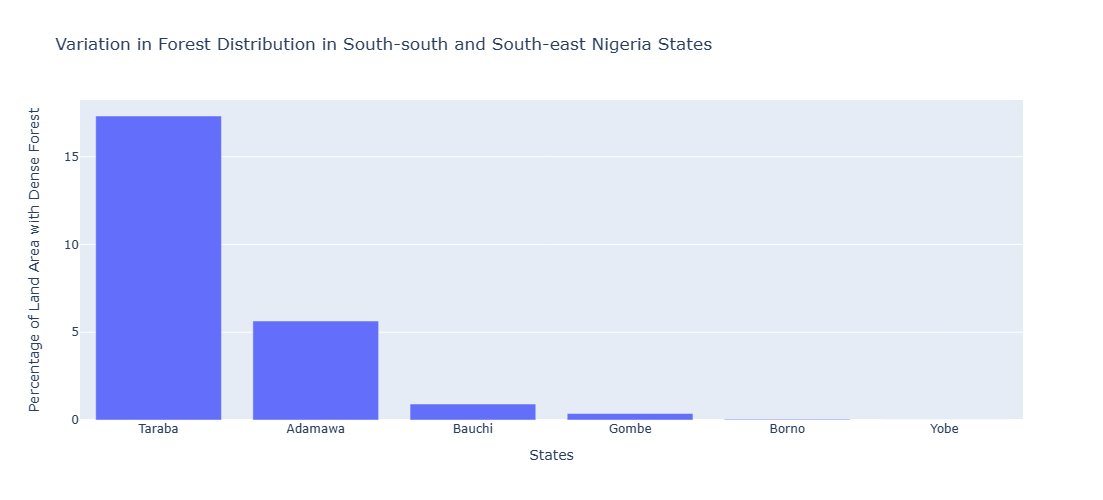

In [92]:
geemap.bar_chart(data=ne_fnf, x='ADM1_NAME', y='class1_percent', x_label= 'States', y_label='Percentage of Land Area with Dense Forest', 
                 title='Variation in Forest Distribution in South-south and South-east Nigeria States')